In [306]:
from pathlib import Path
import pandas as pd
import numpy as np
import pgeocode
from scipy.stats import f_oneway, ttest_ind, pointbiserialr
import statsmodels.api as sm

import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [69]:
pd.set_option('display.max_columns', None)

In [70]:
# Functions for data import

def add_leading_zero_to_zipcode(item):
    item_str = str(item)  # Ensure the item is a string
    item_str = item_str.replace('.0', '') # remove trailing '.0'
    
    if len(item_str) == 4:
        return '0' + item_str
    elif len(item_str) == 3:
        return '00' + item_str
    
    elif item_str == '10072': # catch bad New York Zipcode
        return '10001'
    elif item_str == '30399': # catch bad Atlanta Zipcode
        return '30303'
    elif item_str == '94101': # catch bad San Francisco Zipcode
        return '94102'
    elif item_str == '92164': # catch bad San Diego
        return '92101'
    elif item_str == '98205': # catch bad Everett WA
        return '98201'
    elif item_str == '29573':
        return '29574'
    elif item_str == '19388':
        return '19390'
    elif item_str == '19640': # Reading PA
        return '19601'
    elif item_str == '16532': # Erie PA
        return '16501'
    elif item_str == '14645': # Rochester NY
        return '14604'
    elif item_str == '19483':
        return '19481'      # Valley Forge PA
    elif item_str == '17767':
        return '17751'      # Salona PA
    elif item_str == '45418':
        return '45390'      # Dayton OH
    elif item_str == '30330':
        return '30329'      # Atlanta GA
    elif item_str == '25965': 
        return '25976'      # Elton WV
    
    return item_str

def remove_dollar_and_convert(item):
    # Remove the dollar sign and convert to integer
    return np.int32(item.replace('$', ''))

def remove_dollar_and_convert_float(item):
    # Remove the dollar sign and convert to float
    return np.float64(item.replace('$', ''))

def convert_yes_no_to_binary(item):
    item_lower = str(item).lower()
    if item_lower == 'yes':
        result = 1
    else:
        result = 0 
    return np.int8(result)


In [71]:
# Import users from csv

users_path = Path.cwd() / 'data/sd254_users.csv'


users_columns_import = ['Birth Year', 
                        'Zipcode', 
                        'Per Capita Income - Zipcode',
                        'Yearly Income - Person', 
                        'Total Debt',
                        'FICO Score',
                        'Num Credit Cards']

user_converters = {'Zipcode': add_leading_zero_to_zipcode,
                   'Per Capita Income - Zipcode': remove_dollar_and_convert,
                   'Yearly Income - Person': remove_dollar_and_convert,
                   'Total Debt': remove_dollar_and_convert}

users_dtypes = {'Birth Year': np.uint16,
                 'FICO Score': np.uint16,
                 'Num Credit Cards': np.uint8}

users_df = pd.read_csv(users_path, 
                       usecols=users_columns_import,
                       converters=user_converters,
                       dtype=users_dtypes
                    )


users_df['User'] = users_df.index

users_df.head()


,Birth Year,Zipcode,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User
0,1966,91750,29278,59696,127613,787,5,0
1,1966,11363,37891,77254,191349,701,5,1
2,1938,91792,22681,33483,196,698,5,2
3,1957,10069,163145,249925,202328,722,4,3
4,1976,94117,53797,109687,183855,675,1,4


In [72]:
# import cards csv

cards_path = Path.cwd() / 'data/sd254_cards.csv'

cards_columns_import = ['User',	
                        'CARD INDEX',
                        'Has Chip',
                        'Cards Issued',
                        'Year PIN last Changed',
                        'Card on Dark Web'
                        ]

cards_dtypes = {'CARD INDEX': np.uint8,
                'Cards Issued': np.uint8,
                'Year PIN last Changed': np.uint16
                }

cards_conversions = {'Card on Dark Web': convert_yes_no_to_binary,
                     'Has Chip': convert_yes_no_to_binary}

cards_df = pd.read_csv(cards_path,
                       usecols=cards_columns_import,
                       dtype=cards_dtypes,
                       converters=cards_conversions
                       )

display(cards_df.head())

,User,CARD INDEX,Has Chip,Cards Issued,Year PIN last Changed,Card on Dark Web
0,0,0,1,2,2008,0
1,0,1,1,2,2014,0
2,0,2,1,2,2004,0
3,0,3,0,1,2012,0
4,0,4,1,1,2009,0


In [73]:
transactions_path = Path.cwd() / 'data/credit_card_transactions-ibm_v2.csv'

transactions_columns_import = ['User',
                               'Card',
                               'Year',
                               'Month',
                               'Day',
                               'Time',
                               'Amount',
                               'Use Chip',
                               'Merchant City',
                               'Merchant State',
                               'Zip',
                               'MCC',
                               'Errors?',
                               'Is Fraud?'
                               ]

transaction_converters = {'Zip': add_leading_zero_to_zipcode,
                           'Amount': remove_dollar_and_convert_float,
                           'Is Fraud?': convert_yes_no_to_binary
                          }


transactions_df = pd.read_csv(transactions_path,
                                usecols=transactions_columns_import,
                                converters=transaction_converters
                                )


In [74]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          float64
 7   Use Chip        object 
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             object 
 11  MCC             int64  
 12  Errors?         object 
 13  Is Fraud?       int8   
dtypes: float64(1), int64(6), int8(1), object(6)
memory usage: 2.4+ GB


In [75]:
transactions_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,La Verne,CA,91750,5300,NaN,0
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,Monterey Park,CA,91754,5651,NaN,0
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,La Verne,CA,91750,5912,NaN,0


In [76]:
# inconsistent Merchant City ONLINE and Use Chip Online Transaction
transactions_df.loc[((transactions_df['Merchant City'] == 'ONLINE') & (transactions_df['Use Chip'] != 'Online Transaction')), 'Use Chip'].value_counts()

Use Chip
Chip Transaction    7601
Name: count, dtype: int64

In [77]:
transactions_users_500_df = transactions_df.loc[transactions_df['User'] < 500]
transactions_test_df = transactions_df.loc[transactions_df['User'] < 5]

In [78]:
transactions_users_500_df.to_csv('data/transactions_users_500.csv', index=False)

In [164]:
# merge datasets

# merge_step_1 = transactions_users_500_df.merge(users_df, how='inner', on='User')
merge_step_1 = transactions_test_df.merge(users_df, how='inner', on='User')

merged_df = merge_step_1.merge(cards_df, how='inner', left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99519 entries, 0 to 99518
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User                         99519 non-null  int64  
 1   Card                         99519 non-null  int64  
 2   Year                         99519 non-null  int64  
 3   Month                        99519 non-null  int64  
 4   Day                          99519 non-null  int64  
 5   Time                         99519 non-null  object 
 6   Amount                       99519 non-null  float64
 7   Use Chip                     99519 non-null  object 
 8   Merchant City                99519 non-null  object 
 9   Merchant State               77894 non-null  object 
 10  Zip                          99519 non-null  object 
 11  MCC                          99519 non-null  int64  
 12  Errors?                      1697 non-null   object 
 13  Is Fraud?       

In [165]:
# add column to define whether international
merged_df['International'] = (merged_df['Merchant State'].str.len() > 2).astype(np.int8)

# add column for online transaction
merged_df['Online'] = (transactions_df['Merchant City'] == 'ONLINE').astype(np.int8)

# add column for age at transaction
merged_df['Age_at_transaction'] = (merged_df['Year'] - merged_df['Birth Year']).astype(np.int16)

# create income-to-debt
merged_df['income_to_debt'] = merged_df['Yearly Income - Person'] / (merged_df['Total Debt'] + 0.001)

# create a date-time column
merged_df['datetime'] = pd.to_datetime(merged_df['Year'].astype(str) + '-' + 
                                merged_df['Month'].astype(str) + '-' + 
                                merged_df['Day'].astype(str) + ' ' + 
                                merged_df['Time'])

# create day of week column
merged_df['day_of_week'] = merged_df['datetime'].dt.dayofweek.astype(np.int8)

# Convert datetime to Unix timestamp
merged_df['timestamp'] = merged_df['datetime'].astype(int) / 10**9  # Convert to seconds

In [166]:
# Put times into bins of time-of-day

# Define the bins and their corresponding labels
time_bins = [0, 6, 12, 18, 22, 24]
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']

# Categorize the hours into bins
merged_df['time_of_day'] = pd.cut(merged_df['datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False, include_lowest=True, ordered=False)


In [167]:
# create filters and lists of zipcodes to find distance with
distance_candidates = merged_df['Zip'].str.len() == 5
international_filters = merged_df['International'] == 1
online_filters = merged_df['Online'] == 1


merchant_zip_list = merged_df.loc[distance_candidates, 'Zip'].to_list()
user_zip_list = merged_df.loc[distance_candidates, 'Zipcode'].to_list()

# use pgeocode to calculate distances
dist = pgeocode.GeoDistance('us')
distances = dist.query_postal_code(user_zip_list, merchant_zip_list)

avg_distance = np.mean(distances)
max_distance = np.max(distances)


# initiate distance attribute with average distance
merged_df['distances'] = avg_distance

# populate distances
merged_df.loc[distance_candidates, 'distances'] = distances
merged_df.loc[international_filters, 'distances'] = max_distance
# merged_df.loc[distance_candidates, 'problem_dist'] = np.isnan(distances)


In [83]:
# # Define the bins and their labels
# # a word of caution: https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when

# age_bins = [0, 18, 25, 35, 45, 60, 100]
# age_labels = ['Under 18', '18-25', '26-35', '36-45', '46-60', 'Over 60']

# # Bin the 'Current Age' column
# merged_df['Age_Group_at_Transaction'] = pd.cut(merged_df['Age_at_transaction'], bins=age_bins, labels=age_labels, right=False)

# # Drop the 'Current Age' column after binning
# merged_df = merged_df.drop(columns=['Age_at_transaction'])

In [168]:
merged_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Birth Year,Zipcode,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,CARD INDEX,Has Chip,Cards Issued,Year PIN last Changed,Card on Dark Web,International,Online,Age_at_transaction,income_to_debt,datetime,day_of_week,timestamp,time_of_day,distances
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,La Verne,CA,91750,5300,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-01 06:21:00,6,1.030861e+09,Morning,0.000000
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-01 06:42:00,6,1.030863e+09,Morning,33.540588
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,Monterey Park,CA,91754,5411,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-02 06:22:00,0,1.030948e+09,Morning,33.540588
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,Monterey Park,CA,91754,5651,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-02 17:45:00,0,1.030989e+09,Afternoon,33.540588
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,La Verne,CA,91750,5912,NaN,0,1966,91750,29278,59696,127613,787,5,0,1,2,2008,0,0,0,36,0.467789,2002-09-03 06:23:00,1,1.031034e+09,Morning,0.000000


In [169]:
columns_to_drop = ['Card',
                   'User',
                   'Year',
                   'Month',
                   'Birth Year',
                   'Day',
                   'Time',
                   'Merchant City',
                   'Zip',
                   'Zipcode',
                   'CARD INDEX',
                   'Year PIN last Changed',
                   'MCC',
                   'datetime',
                   'Card on Dark Web'
                   ]

merged_and_drop_df = merged_df.drop(columns=columns_to_drop, axis=1)

# Filter out negative amounts
merged_and_drop_df = merged_and_drop_df.loc[merged_and_drop_df['Amount'] > 0.0]

# replace NaN Errors with No Error
merged_and_drop_df['Errors?'] = merged_and_drop_df['Errors?'].fillna('No Error')

# replace NaN in Merchant State with Online
merged_and_drop_df['Merchant State'] = merged_and_drop_df['Merchant State'].fillna('Online')

merged_and_drop_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,CA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,HI,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


In [170]:
merged_and_drop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96939 entries, 0 to 99518
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Amount                       96939 non-null  float64 
 1   Use Chip                     96939 non-null  object  
 2   Merchant State               96939 non-null  object  
 3   Errors?                      96939 non-null  object  
 4   Is Fraud?                    96939 non-null  int8    
 5   Per Capita Income - Zipcode  96939 non-null  int32   
 6   Yearly Income - Person       96939 non-null  int32   
 7   Total Debt                   96939 non-null  int32   
 8   FICO Score                   96939 non-null  uint16  
 9   Num Credit Cards             96939 non-null  uint8   
 10  Has Chip                     96939 non-null  int8    
 11  Cards Issued                 96939 non-null  uint8   
 12  International                96939 non-null  int8    
 13  Online

In [171]:
# Define categorical and numerical columns
categorical_cols = ['Use Chip',
                    'Merchant State',
                    'Errors?',
                    'Has Chip',
                    'International',
                    'Online',
                    'day_of_week',
                    'Is Fraud?'
                    'time_of_day']
numerical_cols = ['Amount',
                    'Per Capita Income - Zipcode',
                    'Yearly Income - Person',
                    'Total Debt',
                    'FICO Score',
                    'Num Credit Cards',
                    'Cards Issued',
                    'Age_at_transaction',
                    'income_to_debt',
                    'timestamp',
                    'distances']
                    

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])




In [172]:
# Define the model - option 2
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=10, criterion='gini', random_state=42))
])

In [173]:
merged_and_drop_df.loc[merged_and_drop_df['Merchant State'].isnull(), 'Online'].value_counts()

Series([], Name: count, dtype: int64)

In [174]:
merged_and_drop_df['Merchant State'].unique()

array(['CA', 'Online', 'NE', 'IL', 'MO', 'Switzerland', 'IA', 'TX',
       'Estonia', 'NJ', 'NV', 'NY', 'Japan', 'AZ', 'UT', 'FL', 'MI',
       'Mexico', 'WA', 'OH', 'Dominican Republic', 'NM', 'China', 'SC',
       'AK', 'PA', 'VA', 'Portugal', 'HI', 'CT', 'MA', 'MN', 'CO',
       'Italy', 'GA', 'Philippines', 'Jamaica', 'AR', 'Canada', 'OR',
       'WI', 'NC', 'France', 'WV', 'Norway', 'ME', 'NH', 'VT', 'MD', 'AL',
       'KY', 'TN', 'MS', 'New Zealand', 'Netherlands', 'KS', 'ND', 'DC',
       'Sierra Leone', 'Haiti', 'MT', 'South Korea', 'Spain', 'OK',
       'Algeria', 'Egypt', 'WY', 'ID', 'Indonesia', 'RI',
       'United Kingdom', 'Colombia', 'South Africa', 'IN', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'LA', 'Germany', 'Czech Republic', 'India', 'Poland', 'DE',
       'Costa Rica', 'Denmark'], dtype=object)

# Correlation between the columns and Fraud outcome.

In [175]:
# Display the database
merged_and_drop_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,CA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,HI,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


In [176]:
# Cross-checking data
merged_and_drop_df['Use Chip'].nunique()

3

In [177]:
unique_values = merged_and_drop_df['Merchant State'].unique()

In [178]:
print(unique_values)

['CA' 'Online' 'NE' 'IL' 'MO' 'Switzerland' 'IA' 'TX' 'Estonia' 'NJ' 'NV'
 'NY' 'Japan' 'AZ' 'UT' 'FL' 'MI' 'Mexico' 'WA' 'OH' 'Dominican Republic'
 'NM' 'China' 'SC' 'AK' 'PA' 'VA' 'Portugal' 'HI' 'CT' 'MA' 'MN' 'CO'
 'Italy' 'GA' 'Philippines' 'Jamaica' 'AR' 'Canada' 'OR' 'WI' 'NC'
 'France' 'WV' 'Norway' 'ME' 'NH' 'VT' 'MD' 'AL' 'KY' 'TN' 'MS'
 'New Zealand' 'Netherlands' 'KS' 'ND' 'DC' 'Sierra Leone' 'Haiti' 'MT'
 'South Korea' 'Spain' 'OK' 'Algeria' 'Egypt' 'WY' 'ID' 'Indonesia' 'RI'
 'United Kingdom' 'Colombia' 'South Africa' 'IN' 'The Bahamas' 'Singapore'
 'Pakistan' 'Malaysia' 'Mongolia' 'Israel' 'Hong Kong' 'Guatemala' 'Peru'
 'Thailand' 'Sweden' 'Taiwan' 'LA' 'Germany' 'Czech Republic' 'India'
 'Poland' 'DE' 'Costa Rica' 'Denmark']


In [182]:
us_states = {
    'AL': 'USA',
    'AK': 'USA',
    'AZ': 'USA',
    'AR': 'USA',
    'CA': 'USA',
    'CO': 'USA',
    'CT': 'USA',
    'DE': 'USA',
    'DC': 'USA',
    'FL': 'USA',
    'GA': 'USA',
    'HI': 'USA',
    'ID': 'USA',
    'IL': 'USA',
    'IN': 'USA',
    'IA': 'USA',
    'KS': 'USA',
    'KY': 'USA',
    'LA': 'USA',
    'ME': 'USA',
    'MD': 'USA',
    'MA': 'USA',
    'MI': 'USA',
    'MN': 'USA',
    'MS': 'USA',
    'MO': 'USA',
    'MT': 'USA',
    'NE': 'USA',
    'NV': 'USA',
    'NH': 'USA',
    'NJ': 'USA',
    'NM': 'USA',
    'NY': 'USA',
    'NC': 'USA',
    'ND': 'USA',
    'OH': 'USA',
    'OK': 'USA',
    'OR': 'USA',
    'PA': 'USA',
    'RI': 'USA',
    'SC': 'USA',
    'SD': 'USA',
    'TN': 'USA',
    'TX': 'USA',
    'UT': 'USA',
    'VT': 'USA',
    'VA': 'USA',
    'WA': 'USA',
    'WV': 'USA',
    'WI': 'USA',
    'WY': 'USA'
}
# grouped_countries_df = merged_and_drop_df['Merchant State'].replace(us_states)
# Create a copy of the original DataFrame
grouped_countries_df = merged_and_drop_df.copy()

# Replace the values in the 'Merchant State' column using the dictionary
grouped_countries_df['Merchant State'] = grouped_countries_df['Merchant State'].replace(us_states)

In [183]:
grouped_countries_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,USA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,USA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


In [184]:
unique_values = grouped_countries_df['Merchant State'].unique()
print(unique_values)

['USA' 'Online' 'Switzerland' 'Estonia' 'Japan' 'Mexico'
 'Dominican Republic' 'China' 'Portugal' 'Italy' 'Philippines' 'Jamaica'
 'Canada' 'France' 'Norway' 'New Zealand' 'Netherlands' 'Sierra Leone'
 'Haiti' 'South Korea' 'Spain' 'Algeria' 'Egypt' 'Indonesia'
 'United Kingdom' 'Colombia' 'South Africa' 'The Bahamas' 'Singapore'
 'Pakistan' 'Malaysia' 'Mongolia' 'Israel' 'Hong Kong' 'Guatemala' 'Peru'
 'Thailand' 'Sweden' 'Taiwan' 'Germany' 'Czech Republic' 'India' 'Poland'
 'Costa Rica' 'Denmark']


In [185]:
merged_and_drop_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,CA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,HI,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


## Chi Squared Test for Categorical Data
### Merchant City against Fraud Occurence

In [186]:
# Creating a contingency table between 'Merchant State' and 'Is Fraud?'
contingency_table = pd.crosstab(grouped_countries_df['Merchant State'], grouped_countries_df['Is Fraud?'])

# Performing chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 11700.734472840897
P-value: 0.0
Degrees of freedom: 44
Expected frequencies table:
[[3.99496591e+00 5.03409361e-03]
 [7.19093863e+01 9.06136849e-02]
 [1.44817514e+02 1.82485893e-01]
 [2.99622443e+01 3.77557020e-02]
 [1.49811221e+01 1.88778510e-02]
 [2.99622443e+01 3.77557020e-02]
 [1.49811221e+01 1.88778510e-02]
 [2.49685369e+01 3.14630850e-02]
 [2.99622443e+00 3.77557020e-03]
 [1.09861562e+01 1.38437574e-02]
 [6.69156789e+01 8.43210679e-02]
 [8.98867329e+00 1.13267106e-02]
 [1.29836392e+01 1.63608042e-02]
 [1.99748295e+00 2.51704680e-03]
 [3.19597273e+01 4.02727488e-02]
 [2.49685369e+01 3.14630850e-02]
 [2.19723125e+01 2.76875148e-02]
 [6.99119034e+00 8.80966381e-03]
 [1.92757105e+02 2.42895016e-01]
 [4.99370738e+01 6.29261701e-02]
 [4.79395909e+01 6.04091233e-02]
 [2.99622443e+00 3.77557020e-03]
 [3.56550707e+02 4.49292854e-01]
 [2.99622443e+00 3.77557020e-03]
 [8.38942840e+01 1.05715966e-01]
 [5.99244886e+00 7.55114041e-03]
 [8.98867329e+00 1.13267106e-02]
 [2

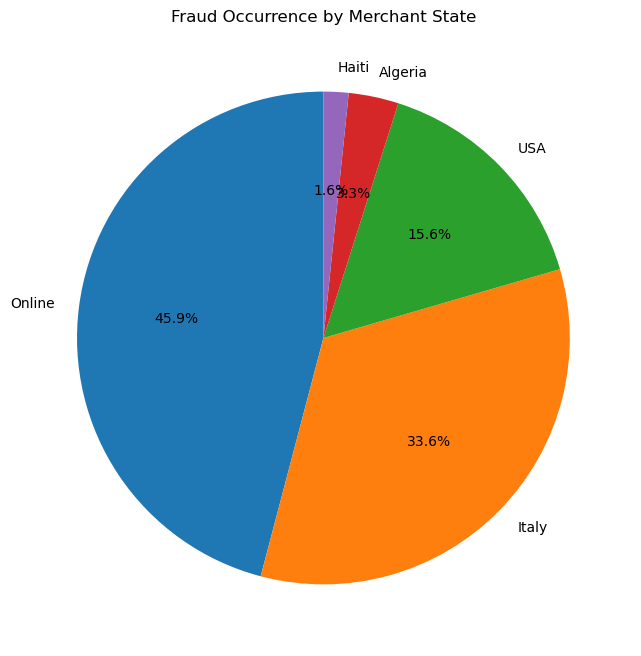

In [237]:
fraud_counts = grouped_countries_df[grouped_countries_df['Is Fraud?'] == 1]['Merchant State'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
fraud_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Fraud Occurrence by Merchant State')
plt.ylabel('')  # Remove the ylabel
plt.show()

This analysis suggests a statistically significant association between the "Merchant State" and "Is Fraud?". It is evident that most fraudulent transactions are online transactions followed by Italy, USA and Algeria.

### Error type against Fraud Occurence

In [189]:
unique_values = merged_and_drop_df['Errors?'].unique()
print(unique_values)

['No Error' 'Technical Glitch' 'Insufficient Balance' 'Bad PIN'
 'Bad PIN,Insufficient Balance' 'Bad Expiration'
 'Bad PIN,Technical Glitch' 'Bad Card Number' 'Bad CVV' 'Bad Zipcode'
 'Insufficient Balance,Technical Glitch'
 'Bad Card Number,Insufficient Balance' 'Bad Card Number,Bad CVV']


In [193]:
errors = {
    'Technical Glitch': 'Error',
    'Insufficient Balance': 'Error',
    'Bad PIN': 'Error',
    'Bad PIN,Insufficient Balance': 'Error',
    'Bad PIN,Technical Glitch': 'Error',
    'Bad Card Number': 'Error',
    'Bad CVV': 'Error',
    'Bad Zipcode': 'Error',
    'Insufficient Balance,Technical Glitch': 'Error',
    'Bad Card Number,Insufficient Balance': 'Error',
    'Bad Card Number,Bad CVV': 'Error',
    'Bad Expiration' : 'Error'
}
# grouped_countries_df = merged_and_drop_df['Merchant State'].replace(us_states)
# Create a copy of the original DataFrame
grouped_errors_df = merged_and_drop_df.copy()

# Replace the values in the 'Merchant State' column using the dictionary
grouped_errors_df['Errors?'] = grouped_countries_df['Errors?'].replace(errors)

In [194]:
grouped_errors_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,CA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,HI,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


In [195]:
unique_values = grouped_errors_df['Errors?'].unique()
print(unique_values)

['No Error' 'Error']


In [196]:
# Creating a contingency table between 'Errors?' and 'Is Fraud?'
errors_table = pd.crosstab(grouped_errors_df['Errors?'], grouped_errors_df['Is Fraud?'])

# Performing chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(errors_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 9.3339091789742
P-value: 0.002249519565567923
Degrees of freedom: 1
Expected frequencies table:
[[1.67189323e+03 2.10676817e+00]
 [9.51451068e+04 1.19893232e+02]]


In [205]:
# Checking the values for non-fraudulent transactions
non_fraud_counts = grouped_errors_df[grouped_errors_df['Is Fraud?'] == 0]['Errors?'].value_counts()
non_fraud_counts

Errors?
No Error    95150
Error        1667
Name: count, dtype: int64

In [204]:
# Checking the values for fraudulent transactions
fraud_counts = grouped_errors_df[grouped_errors_df['Is Fraud?'] == 1]['Errors?'].value_counts()
fraud_counts

Errors?
No Error    115
Error         7
Name: count, dtype: int64

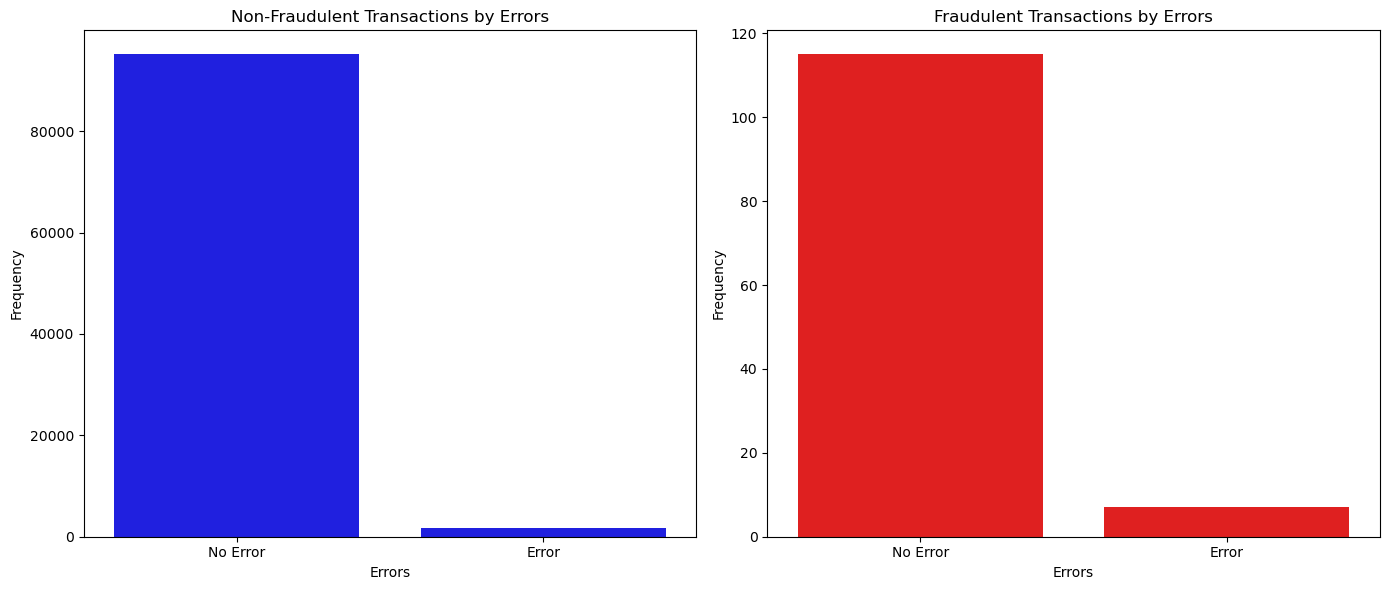

In [225]:
# Plotting the results to visualze the relationship
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=grouped_errors_df[grouped_errors_df['Is Fraud?'] == 0], x='Errors?', color='blue')
plt.title('Non-Fraudulent Transactions by Errors')
plt.xlabel('Errors')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(data=grouped_errors_df[grouped_errors_df['Is Fraud?'] == 1], x='Errors?', color='red')
plt.title('Fraudulent Transactions by Errors')
plt.xlabel('Errors')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Type of transaction and Fraud Occurence

In [201]:
unique_values = merged_and_drop_df['Use Chip'].unique()
print(unique_values)

['Swipe Transaction' 'Online Transaction' 'Chip Transaction']


In [206]:
# Creating a contingency table between 'Use Chip' and 'Is Fraud?'
chip_table = pd.crosstab(merged_and_drop_df['Use Chip'], merged_and_drop_df['Is Fraud?'])

# Performing chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(chip_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 43.15163588099636
P-value: 4.263255155258847e-10
Degrees of freedom: 2
Expected frequencies table:
[[1.78265366e+04 2.24633842e+01]
 [2.14449770e+04 2.70230145e+01]
 [5.75454864e+04 7.25136013e+01]]


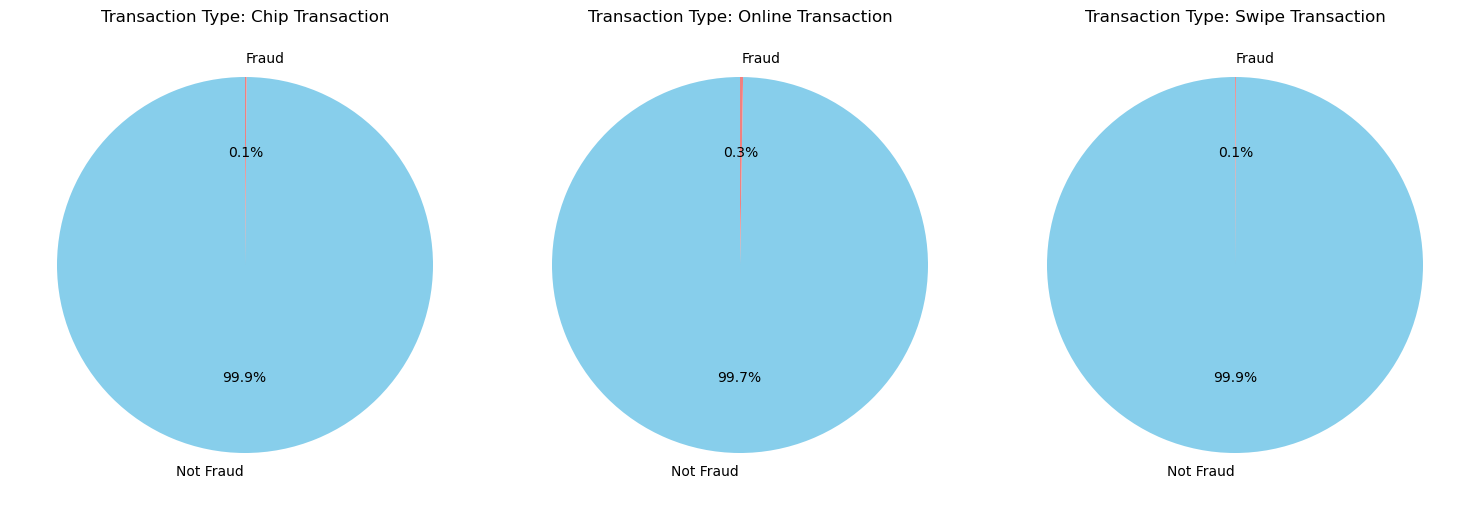

In [230]:
# Plotting the results
fraud_by_chip_usage = merged_and_drop_df.groupby('Use Chip')['Is Fraud?'].mean()

# Creating a pie chart for each category of 'Chip Usage'
fig, axs = plt.subplots(1, len(fraud_by_chip_usage), figsize=(15, 5))  # Adjust figsize as needed

# Iterating over each category of 'Chip Usage' and creating a pie chart
for i, (chip_usage, fraud_proportion) in enumerate(fraud_by_chip_usage.items()):
    axs[i].pie([1 - fraud_proportion, fraud_proportion], labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    axs[i].set_title(f'Transaction Type: {chip_usage}')

plt.tight_layout()
plt.show()

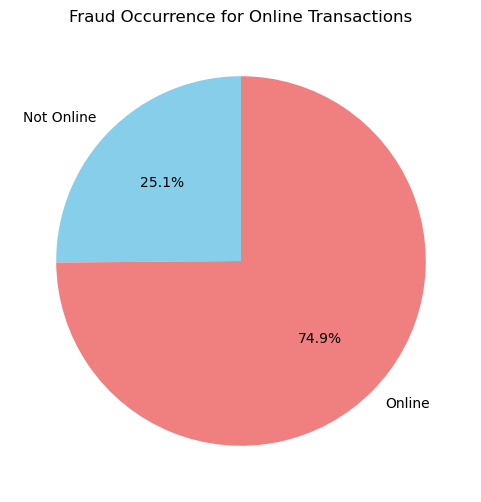

In [312]:
# Checking online category closely
fraud_by_online = merged_and_drop_df.groupby('Online')['Is Fraud?'].mean()

# Create a pie chart for 'Online' transactions
plt.figure(figsize=(6, 6))
plt.pie(fraud_by_online, labels=['Not Online', 'Online'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Fraud Occurrence for Online Transactions')
plt.show()


# Distribution
total_transactions = len(merged_and_drop_df)

# Calculating the number of online transactions
num_online_transactions = merged_and_drop_df['Online'].sum()

# Calculating the number of non-online transactions
num_non_online_transactions = total_transactions - num_online_transactions

# Grouping by 'Online' and calculate the proportion of fraud for each category
fraud_by_online = merged_and_drop_df.groupby('Online')['Is Fraud?'].mean()



### Analysis
The analysis highlights a significant correlation between online transactions and fraud occurrence, revealing that nearly 75% of the examined fraudulent transactions originate from online channels. This suggests a strong association between conducting transactions over the internet and the likelihood of encountering fraudulent activities.

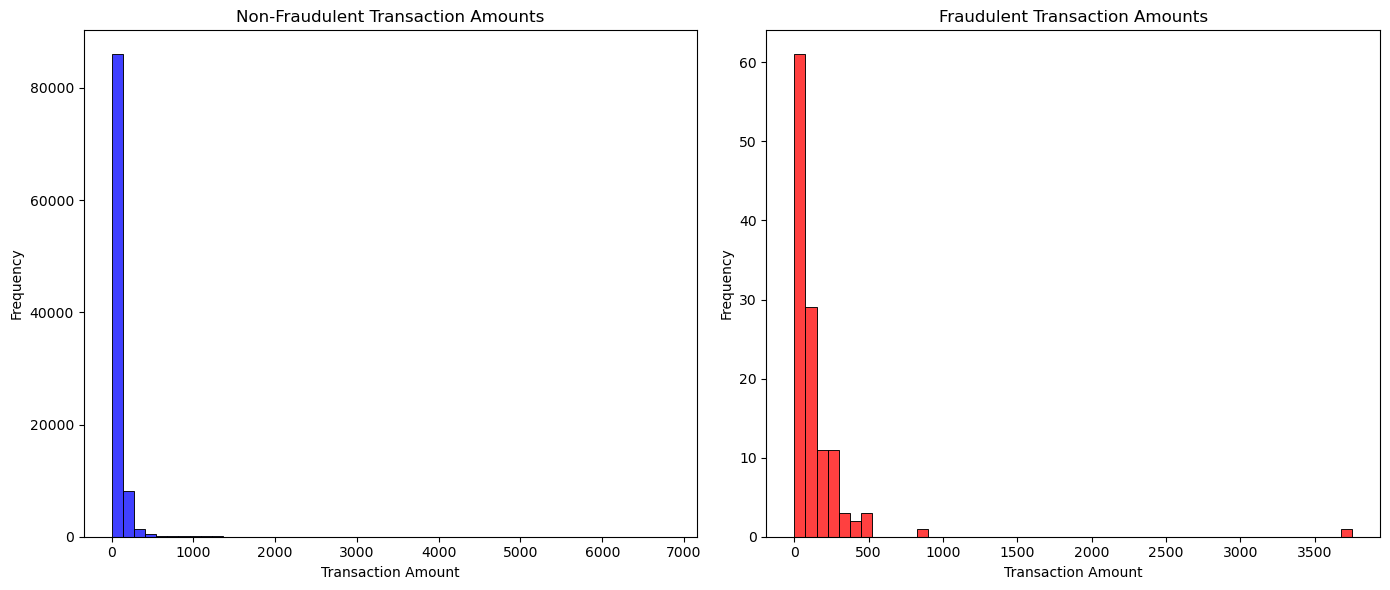

In [238]:
# Testing the relationship between Amount Apent and Fraud Occurance
df = merged_and_drop_df

# Plotting the histogram for transaction amounts, separated by fraud and non-fraud
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Is Fraud?'] == 0]['Amount'], bins=50, color='blue', kde=False)
plt.title('Non-Fraudulent Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df[df['Is Fraud?'] == 1]['Amount'], bins=50, color='red', kde=False)
plt.title('Fraudulent Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Verifying the results
#max_amount = merged_and_drop_df['Amount'].max()
#min_amount = merged_and_drop_df['Amount'].min()

### Logistic regression and ttest_ind

In [260]:
# Assuming 'amount' is the transaction amount and 'fraud' is the binary fraud occurrence
X = sm.add_constant(merged_and_drop_df['Amount'])  # Add constant for intercept
y = merged_and_drop_df['Is Fraud?']

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.009599
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              Is Fraud?   No. Observations:                96939
Model:                          Logit   Df Residuals:                    96937
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 May 2024   Pseudo R-squ.:                0.006557
Time:                        17:15:46   Log-Likelihood:                -930.48
converged:                       True   LL-Null:                       -936.62
Covariance Type:            nonrobust   LLR p-value:                 0.0004571
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7676      0.094    -71.818      0.000      -6.952      -6.583
Amount         0.0010      0

In [261]:
# Subsetting data into fraud and non-fraud cases
fraud_data = merged_and_drop_df[merged_and_drop_df['Is Fraud?'] == 1]['Amount']
non_fraud_data = merged_and_drop_df[merged_and_drop_df['Is Fraud?'] == 0]['Amount']

# Performing independent samples t-test
t_statistic, p_value = ttest_ind(fraud_data, non_fraud_data, equal_var=False)

# Printing t-test results
print("Independent Samples t-test results:")
print("T-statistic:", t_statistic)
print("p-value:", p_value)

Independent Samples t-test results:
T-statistic: 2.2300182120876237
p-value: 0.027589898794771046


### Analysis
ttest_ind results: Transaction amounts differ significantly between fraudulent and non-fraudulent transactions, as indicated by a statistically significant T-statistic (T = 2.23, p < 0.05).

Logistic regression results: The logistic regression model suggests that transaction amount is a statistically significant predictor of fraud occurrence (p < 0.05), with higher transaction amounts associated with an increased likelihood of fraud.

Based on the visualization it is evident that the usual fraudulent transaction has an amount equivalent up to $500.

### Time of the day against Fraud Occurence

In [202]:
# Creating a contingency table between 'time_of_day' and 'Is Fraud?'
day_night_table = pd.crosstab(merged_and_drop_df['time_of_day'], merged_and_drop_df['Is Fraud?'])

# Performing chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(day_night_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 39.833642931439456
P-value: 1.1556288898388658e-08
Degrees of freedom: 3
Expected frequencies table:
[[2.83043334e+04 3.56665532e+01]
 [7.48656611e+03 9.43389142e+00]
 [4.65773075e+04 5.86924973e+01]
 [1.44487929e+04 1.82070580e+01]]


We can reject the null hypothesis of independence. This suggests that there is a significant association between the time of day and fraud occurence in the dataset. 

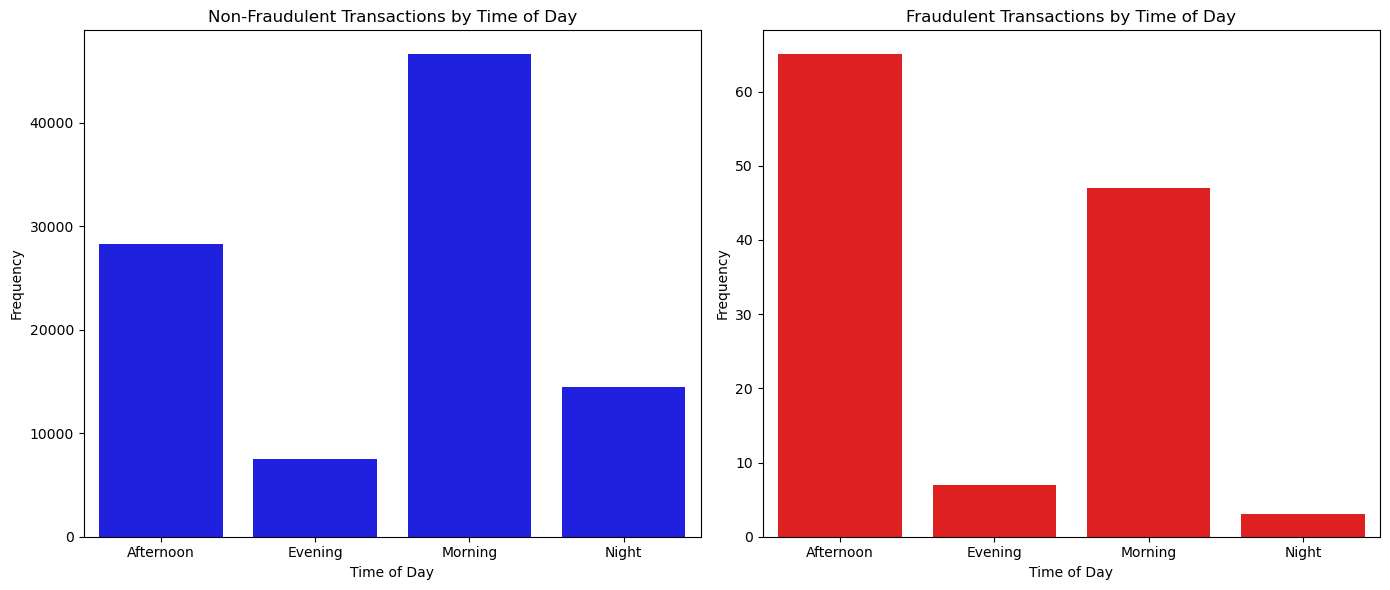

In [222]:

# Plot the histogram for transaction times, separated by fraud and non-fraud
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df[df['Is Fraud?'] == 0], x='time_of_day', color='blue')
plt.title('Non-Fraudulent Transactions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(data=df[df['Is Fraud?'] == 1], x='time_of_day', color='red')
plt.title('Fraudulent Transactions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Analysis
It is quite evident that Fraud is more likely to occur during the afternoon and morning hours.

### Day of the week and Fraud

In [97]:

# Creating a contingency table between 'day_of_week' and 'Is Fraud?'
week_table = pd.crosstab(merged_and_drop_df['day_of_week'], merged_and_drop_df['Is Fraud?'])

# Performing chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(week_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 11.792856174366353
P-value: 0.06675271645094703
Degrees of freedom: 6
Expected frequencies table:
[[13986.37563829    17.62436171]
 [13624.83122376    17.16877624]
 [13723.70662994    17.29337006]
 [13886.50149063    17.49850937]
 [13982.38067238    17.61932762]
 [13755.66635719    17.33364281]
 [13857.53798781    17.46201219]]


This suggests that there is a significant association between the weekday and fraud occurrence in the dataset. In other words, the occurrence of fraud is not independent of the weekday.

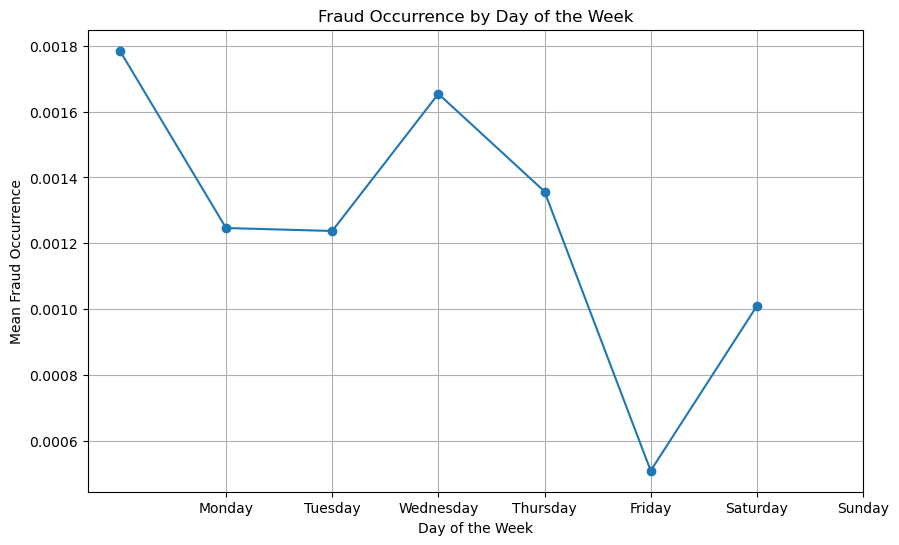

In [242]:
fraud_by_day = merged_and_drop_df.groupby('day_of_week')['Is Fraud?'].mean()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(fraud_by_day.index, fraud_by_day.values, marker='o', linestyle='-')
plt.title('Fraud Occurrence by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Fraud Occurrence')
plt.xticks(range(1, 8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

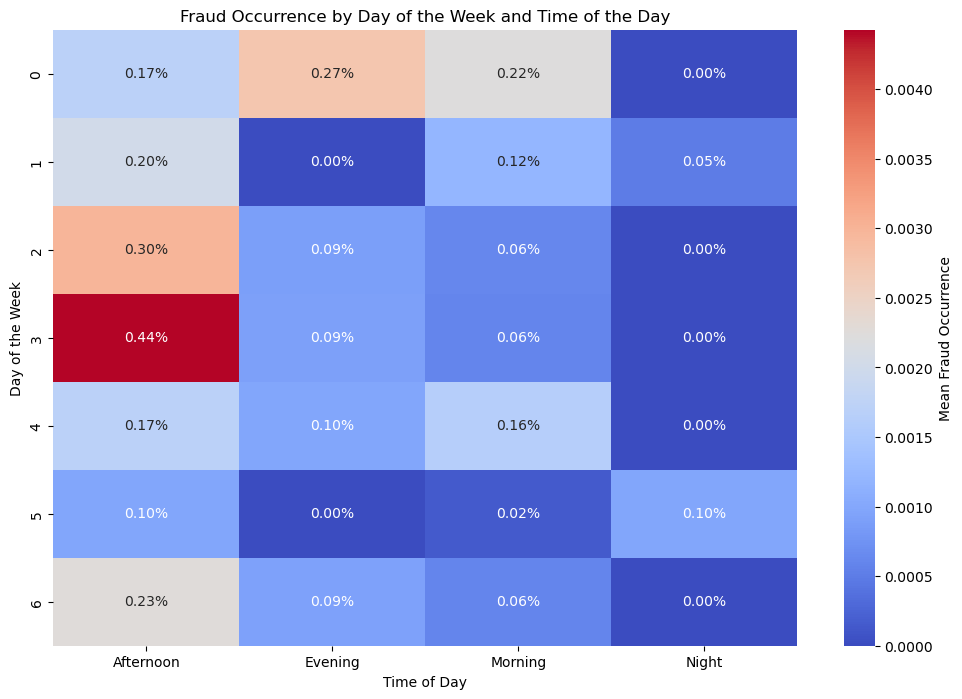

In [248]:
fraud_by_day_time = merged_and_drop_df.groupby(['day_of_week', 'time_of_day'])['Is Fraud?'].mean().reset_index()

# Pivotting the DataFrame to create a matrix suitable for heatmap
heatmap_data = fraud_by_day_time.pivot(index='day_of_week', columns='time_of_day', values='Is Fraud?')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2%", cbar_kws={'label': 'Mean Fraud Occurrence'})
plt.title('Fraud Occurrence by Day of the Week and Time of the Day')
plt.xlabel('Time of Day')
plt.ylabel('Day of the Week')
plt.show()

Flagged day and time:
- Monday Evening
- Wednesday Afternoon
- Thursday Afternoon (highest fraud occurence)


### Testing Correlation between each column and row in the dataset
It was used to cross-check all the results and take final conclusions/ gain more insight on the dataset.

In [98]:
# Loading the data
merged_and_drop_df

# Performing one-hot encoding for categorical variables
data_encoded = pd.get_dummies(merged_and_drop_df)

# Handling non-numeric values in numerical columns 
data_encoded = data_encoded.apply(pd.to_numeric, errors='coerce')

# Calculating correlation with 'Is Fraud?' column for each variable
correlations = {}
for column in data_encoded.columns:
    correlation, p_value = st.pearsonr(data_encoded[column], data_encoded['Is Fraud?'])
    correlations[column] = {'correlation': correlation, 'p_value': p_value}

# Visualizing the results
for column, values in correlations.items():
    print(f"Correlation between {column} and Is Fraud?: {values['correlation']:.2f}, p-value: {values['p_value']:.2f}")

Correlation between Amount and Is Fraud?: 0.02, p-value: 0.00
Correlation between Is Fraud? and Is Fraud?: 1.00, p-value: 0.00
Correlation between Per Capita Income - Zipcode and Is Fraud?: 0.01, p-value: 0.07
Correlation between Yearly Income - Person and Is Fraud?: 0.01, p-value: 0.11
Correlation between Total Debt and Is Fraud?: 0.01, p-value: 0.03
Correlation between FICO Score and Is Fraud?: 0.01, p-value: 0.06
Correlation between Num Credit Cards and Is Fraud?: 0.01, p-value: 0.00
Correlation between Has Chip and Is Fraud?: 0.00, p-value: 0.55
Correlation between Cards Issued and Is Fraud?: -0.00, p-value: 0.23
Correlation between International and Is Fraud?: 0.10, p-value: 0.00
Correlation between Online and Is Fraud?: 0.02, p-value: 0.00
Correlation between Age_at_transaction and Is Fraud?: 0.01, p-value: 0.09
Correlation between income_to_debt and Is Fraud?: -0.01, p-value: 0.07
Correlation between day_of_week and Is Fraud?: -0.01, p-value: 0.02
Correlation between timestamp a

In [99]:
# Checking which state has been most affected
# Creating data from the results
results_merchant_state = """
Correlation between Merchant State_AA and Is Fraud?: -0.00, p-value: 0.93
Correlation between Merchant State_AK and Is Fraud?: -0.00, p-value: 0.04
Correlation between Merchant State_AL and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_AR and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_AZ and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_Algeria and Is Fraud?: 0.17, p-value: 0.00
Correlation between Merchant State_Argentina and Is Fraud?: -0.00, p-value: 0.81
Correlation between Merchant State_Aruba and Is Fraud?: -0.00, p-value: 0.57
Correlation between Merchant State_Australia and Is Fraud?: -0.00, p-value: 0.62
Correlation between Merchant State_Austria and Is Fraud?: -0.00, p-value: 0.60
Correlation between Merchant State_Bangladesh and Is Fraud?: -0.00, p-value: 0.86
Correlation between Merchant State_Barbados and Is Fraud?: -0.00, p-value: 0.76
Correlation between Merchant State_Belarus and Is Fraud?: -0.00, p-value: 0.95
Correlation between Merchant State_Belgium and Is Fraud?: -0.00, p-value: 0.74
Correlation between Merchant State_Benin and Is Fraud?: -0.00, p-value: 0.94
Correlation between Merchant State_Brazil and Is Fraud?: -0.00, p-value: 0.67
Correlation between Merchant State_Burkina Faso and Is Fraud?: -0.00, p-value: 0.91
Correlation between Merchant State_CA and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_CO and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_CT and Is Fraud?: -0.00, p-value: 0.21
Correlation between Merchant State_Cambodia and Is Fraud?: -0.00, p-value: 0.82
Correlation between Merchant State_Cameroon and Is Fraud?: -0.00, p-value: 0.89
Correlation between Merchant State_Canada and Is Fraud?: -0.00, p-value: 0.01
Correlation between Merchant State_Chile and Is Fraud?: -0.00, p-value: 0.80
Correlation between Merchant State_China and Is Fraud?: -0.00, p-value: 0.22
Correlation between Merchant State_Colombia and Is Fraud?: -0.00, p-value: 0.59
Correlation between Merchant State_Costa Rica and Is Fraud?: -0.00, p-value: 0.54
Correlation between Merchant State_Croatia and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_Cyprus and Is Fraud?: -0.00, p-value: 0.95
Correlation between Merchant State_Czech Republic and Is Fraud?: -0.00, p-value: 0.68
Correlation between Merchant State_DC and Is Fraud?: -0.00, p-value: 0.19
Correlation between Merchant State_DE and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Denmark and Is Fraud?: -0.00, p-value: 0.71
Correlation between Merchant State_Djibouti and Is Fraud?: -0.00, p-value: 0.90
Correlation between Merchant State_Dominican Republic and Is Fraud?: -0.00, p-value: 0.36
Correlation between Merchant State_Ecuador and Is Fraud?: -0.00, p-value: 0.91
Correlation between Merchant State_Egypt and Is Fraud?: -0.00, p-value: 0.75
Correlation between Merchant State_Eritrea and Is Fraud?: -0.00, p-value: 0.87
Correlation between Merchant State_Estonia and Is Fraud?: -0.00, p-value: 0.81
Correlation between Merchant State_Ethiopia and Is Fraud?: -0.00, p-value: 0.94
Correlation between Merchant State_FL and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_Fiji and Is Fraud?: 0.03, p-value: 0.00
Correlation between Merchant State_Finland and Is Fraud?: -0.00, p-value: 0.80
Correlation between Merchant State_France and Is Fraud?: -0.00, p-value: 0.20
Correlation between Merchant State_GA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Georgia and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_Germany and Is Fraud?: -0.00, p-value: 0.21
Correlation between Merchant State_Ghana and Is Fraud?: -0.00, p-value: 0.94
Correlation between Merchant State_Greece and Is Fraud?: -0.00, p-value: 0.60
Correlation between Merchant State_Guatemala and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_HI and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Haiti and Is Fraud?: 0.10, p-value: 0.00
Correlation between Merchant State_Honduras and Is Fraud?: -0.00, p-value: 0.96
Correlation between Merchant State_Hong Kong and Is Fraud?: -0.00, p-value: 0.58
Correlation between Merchant State_Hungary and Is Fraud?: -0.00, p-value: 0.70
Correlation between Merchant State_IA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_ID and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_IL and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_IN and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Iceland and Is Fraud?: -0.00, p-value: 0.84
Correlation between Merchant State_India and Is Fraud?: -0.00, p-value: 0.35
Correlation between Merchant State_Indonesia and Is Fraud?: -0.00, p-value: 0.74
Correlation between Merchant State_Iran and Is Fraud?: -0.00, p-value: 0.86
Correlation between Merchant State_Ireland and Is Fraud?: -0.00, p-value: 0.50
Correlation between Merchant State_Israel and Is Fraud?: -0.00, p-value: 0.47
Correlation between Merchant State_Italy and Is Fraud?: 0.27, p-value: 0.00
Correlation between Merchant State_Jamaica and Is Fraud?: -0.00, p-value: 0.40
Correlation between Merchant State_Japan and Is Fraud?: 0.00, p-value: 0.00
Correlation between Merchant State_KS and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_KY and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Kenya and Is Fraud?: -0.00, p-value: 0.95
Correlation between Merchant State_Kiribati and Is Fraud?: -0.00, p-value: 0.97
Correlation between Merchant State_Kosovo and Is Fraud?: -0.00, p-value: 0.93
Correlation between Merchant State_Kuwait and Is Fraud?: -0.00, p-value: 0.91
Correlation between Merchant State_LA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Latvia and Is Fraud?: -0.00, p-value: 0.86
Correlation between Merchant State_Liechtenstein and Is Fraud?: -0.00, p-value: 0.96
Correlation between Merchant State_Lithuania and Is Fraud?: -0.00, p-value: 0.83
Correlation between Merchant State_Luxembourg and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_MA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_MD and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_ME and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_MI and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_MN and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_MO and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_MS and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_MT and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Mexico and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Moldova and Is Fraud?: -0.00, p-value: 0.78
Correlation between Merchant State_Monaco and Is Fraud?: -0.00, p-value: 0.86
Correlation between Merchant State_Mongolia and Is Fraud?: -0.00, p-value: 0.96
Correlation between Merchant State_Montenegro and Is Fraud?: -0.00, p-value: 0.98
Correlation between Merchant State_Morocco and Is Fraud?: -0.00, p-value: 0.80
Correlation between Merchant State_NC and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_ND and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NE and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NH and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NJ and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NL and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NM and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NV and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_NY and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Nigeria and Is Fraud?: -0.00, p-value: 0.90
Correlation between Merchant State_Norway and Is Fraud?: -0.00, p-value: 0.93
Correlation between Merchant State_OH and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_OK and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_OM and Is Fraud?: -0.00, p-value: 0.98
Correlation between Merchant State_OR and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_PA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Panama and Is Fraud?: -0.00, p-value: 0.81
Correlation between Merchant State_Peru and Is Fraud?: -0.00, p-value: 0.97
Correlation between Merchant State_Philippines and Is Fraud?: -0.00, p-value: 0.61
Correlation between Merchant State_Poland and Is Fraud?: -0.00, p-value: 0.79
Correlation between Merchant State_Portugal and Is Fraud?: -0.00, p-value: 0.79
Correlation between Merchant State_PR and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_RI and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_Romania and Is Fraud?: -0.00, p-value: 0.82
Correlation between Merchant State_Russia and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_RW and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_SA and Is Fraud?: -0.00, p-value: 0.77
Correlation between Merchant State_SD and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_SE and Is Fraud?: -0.00, p-value: 0.56
Correlation between Merchant State_SG and Is Fraud?: -0.00, p-value: 0.59
Correlation between Merchant State_SI and Is Fraud?: -0.00, p-value: 0.81
Correlation between Merchant State_Slovenia and Is Fraud?: -0.00, p-value: 0.83
Correlation between Merchant State_Spain and Is Fraud?: -0.00, p-value: 0.19
Correlation between Merchant State_Sri Lanka and Is Fraud?: -0.00, p-value: 0.81
Correlation between Merchant State_Sudan and Is Fraud?: -0.00, p-value: 0.94
Correlation between Merchant State_Suriname and Is Fraud?: -0.00, p-value: 0.91
Correlation between Merchant State_Sweden and Is Fraud?: -0.00, p-value: 0.60
Correlation between Merchant State_Switzerland and Is Fraud?: -0.00, p-value: 0.72
Correlation between Merchant State_TN and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_TX and Is Fraud?: -0.01, p-value: 0.00
Correlation between Merchant State_Taiwan and Is Fraud?: -0.00, p-value: 0.57
Correlation between Merchant State_Tanzania and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_Thailand and Is Fraud?: -0.00, p-value: 0.50
Correlation between Merchant State_Trinidad and Is Fraud?: -0.00, p-value: 0.98
Correlation between Merchant State_Turkey and Is Fraud?: -0.00, p-value: 0.98
Correlation between Merchant State_UG and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_UA and Is Fraud?: -0.00, p-value: 0.95
Correlation between Merchant State_UK and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_US and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_Uganda and Is Fraud?: -0.00, p-value: 0.88
Correlation between Merchant State_Ukraine and Is Fraud?: -0.00, p-value: 0.93
Correlation between Merchant State_Uruguay and Is Fraud?: -0.00, p-value: 0.76
Correlation between Merchant State_VA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_VE and Is Fraud?: -0.00, p-value: 0.65
Correlation between Merchant State_VN and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_Vanuatu and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_Venezuela and Is Fraud?: -0.00, p-value: 0.65
Correlation between Merchant State_Vietnam and Is Fraud?: -0.00, p-value: 0.92
Correlation between Merchant State_WA and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_WI and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_WV and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_WY and Is Fraud?: -0.00, p-value: 0.00
Correlation between Merchant State_ZA and Is Fraud?: -0.00, p-value: 0.77
"""

# Extracting the correlation data using regex
pattern = re.compile(r'Correlation between (.*?) and Is Fraud\?: (-?\d+\.\d+), p-value: (\d+\.\d+)')
matches = pattern.findall(results_merchant_state)

# Converting to a DataFrame
df = pd.DataFrame(matches, columns=['Merchant_State', 'Correlation', 'P_value'])
df['Correlation'] = df['Correlation'].astype(float)
df['P_value'] = df['P_value'].astype(float)

# Finding the three highest correlations
top_3_correlations = df.loc[df['Correlation'].abs().nlargest(3).index]

top_3_correlations

,Merchant_State,Correlation,P_value
65,Merchant State_Italy,0.27,0.0
5,Merchant State_Algeria,0.17,0.0
51,Merchant State_Haiti,0.10,0.0


### International Transactions vs Fraud Occurence Correlation

In [268]:
# Calculating the point-biserial correlation coefficient
correlation, p_value = pointbiserialr(merged_and_drop_df['International'], merged_and_drop_df['Is Fraud?'])

print("Point-biserial correlation coefficient:", correlation)
print("p-value:", p_value)

Point-biserial correlation coefficient: 0.09897350504753159
p-value: 1.582757252686257e-209


## Analysis
1. International Transactions: There is a correlation of 0.09 between international transactions and fraud, indicating that transactions involving international entities might have a higher likelihood of being fraudulent. Specifically countries like Italy, Algeria and Haiti.

2. Online Transactions: A correlation of 0.05 between online transactions and fraud suggests that transactions conducted online may be more susceptible to fraud.

3. Use of Chip for Online Transactions: Another positive correlation of 0.05 suggests that using a chip for online transactions might correlate with a higher incidence of fraud.

4. Merchant State: While there are various correlations with merchant states, some have statistically significant correlations with fraud. Because the data is mainly based on USA market the fraud occurance is the highest over there (with no specific Merchat picked as more fraudulent). Other Merchant States listed are Internationally based as mentioned before Italy, Algeria and Haiti having the highest rate.


### Neural Network and Other Model's Tests
Performed on a smaller dataset (>5 Users). Please note, Neural Network and its performance based on >100 is available for viewing in file `neuro_network_aleks.ipynb`

In [102]:
# Re-writing the dataframe
model_df = merged_and_drop_df
# Convert categorical data to numeric with `pd.get_dummies`
dummies = pd.get_dummies(model_df)
dummies.head()

,Amount,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,distances,Use Chip_Chip Transaction,Use Chip_Online Transaction,Use Chip_Swipe Transaction,Merchant State_AK,Merchant State_AL,Merchant State_AR,Merchant State_AZ,Merchant State_Algeria,Merchant State_CA,Merchant State_CO,Merchant State_CT,Merchant State_Canada,Merchant State_China,Merchant State_Colombia,Merchant State_Costa Rica,Merchant State_Czech Republic,Merchant State_DC,Merchant State_DE,Merchant State_Denmark,Merchant State_Dominican Republic,Merchant State_Egypt,Merchant State_Estonia,Merchant State_FL,Merchant State_France,Merchant State_GA,Merchant State_Germany,Merchant State_Guatemala,Merchant State_HI,Merchant State_Haiti,Merchant State_Hong Kong,Merchant State_IA,Merchant State_ID,Merchant State_IL,Merchant State_IN,Merchant State_India,Merchant State_Indonesia,Merchant State_Israel,Merchant State_Italy,Merchant State_Jamaica,Merchant State_Japan,Merchant State_KS,Merchant State_KY,Merchant State_LA,Merchant State_MA,Merchant State_MD,Merchant State_ME,Merchant State_MI,Merchant State_MN,Merchant State_MO,Merchant State_MS,Merchant State_MT,Merchant State_Malaysia,Merchant State_Mexico,Merchant State_Mongolia,Merchant State_NC,Merchant State_ND,Merchant State_NE,Merchant State_NH,Merchant State_NJ,Merchant State_NM,Merchant State_NV,Merchant State_NY,Merchant State_Netherlands,Merchant State_New Zealand,Merchant State_Norway,Merchant State_OH,Merchant State_OK,Merchant State_OR,Merchant State_Online,Merchant State_PA,Merchant State_Pakistan,Merchant State_Peru,Merchant State_Philippines,Merchant State_Poland,Merchant State_Portugal,Merchant State_RI,Merchant State_SC,Merchant State_Sierra Leone,Merchant State_Singapore,Merchant State_South Africa,Merchant State_South Korea,Merchant State_Spain,Merchant State_Sweden,Merchant State_Switzerland,Merchant State_TN,Merchant State_TX,Merchant State_Taiwan,Merchant State_Thailand,Merchant State_The Bahamas,Merchant State_UT,Merchant State_United Kingdom,Merchant State_VA,Merchant State_VT,Merchant State_WA,Merchant State_WI,Merchant State_WV,Merchant State_WY,Errors?_Bad CVV,Errors?_Bad Card Number,"Errors?_Bad Card Number,Bad CVV","Errors?_Bad Card Number,Insufficient Balance",Errors?_Bad Expiration,Errors?_Bad PIN,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_No Error,Errors?_Technical Glitch,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,134.09,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,0.000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
1,38.48,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,33.540588,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [103]:
model_df['Is Fraud?'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [104]:
# Splitting  preprocessed data 
y = dummies['Is Fraud?'].values
X = dummies.drop(columns='Is Fraud?').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [105]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [106]:
import tensorflow as tf

# Defining the model
features_total = len(X_train[0])
nodes_layer1 = 8
nodes_layer2 = 5
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = nodes_layer1, input_dim = features_total, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = 'relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

# Check the structure of the model
nn.summary()

/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8)              │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091 (4.26 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Compiling the model
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [108]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9881 - loss: 0.1409
Epoch 2/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9986 - loss: 0.0074
Epoch 3/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9989 - loss: 0.0056
Epoch 4/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9987 - loss: 0.0051
Epoch 5/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9987 - loss: 0.0055
Epoch 6/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9988 - loss: 0.0054
Epoch 7/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9988 - loss: 0.0050
Epoch 8/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9988 - loss: 0.0047
Epoch 9/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9988 - loss: 0.0047
Epoch 10/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9987 - loss: 0.0048
Epoch 11/100
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9987 - loss: 0.0047
Epoch 12/100
227

In [109]:
# Evaluating the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

758/758 - 2s - 3ms/step - accuracy: 0.9991 - loss: 0.0064
Loss: 0.006409485824406147, Accuracy: 0.9990509748458862


### Feature importance and Random Forest


In [287]:
# Standardizing the dataset to improve readability
# Create a copy of the original DataFrame
forest_df = merged_and_drop_df.copy()

# Replace the values in the 'Errors?' column using the errors dictionary
forest_df['Errors?'] = forest_df['Errors?'].replace(errors)

# Replace the values in the 'Merchant State' column using the us_states dictionary
forest_df['Merchant State'] = forest_df['Merchant State'].replace(us_states)

In [272]:
forest_df

,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Has Chip,Cards Issued,International,Online,Age_at_transaction,income_to_debt,day_of_week,timestamp,time_of_day,distances
0,134.09,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030861e+09,Morning,0.000000
1,38.48,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,6,1.030863e+09,Morning,33.540588
2,120.34,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030948e+09,Morning,33.540588
3,128.95,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,0,1.030989e+09,Afternoon,33.540588
4,104.71,Swipe Transaction,USA,No Error,0,29278,59696,127613,787,5,1,2,0,0,36,0.467789,1,1.031034e+09,Morning,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99514,99.94,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582797e+09,Morning,246.510932
99515,83.34,Chip Transaction,USA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582817e+09,Afternoon,0.000000
99516,27.24,Online Transaction,Online,No Error,0,53797,109687,183855,675,1,1,1,0,1,44,0.596595,3,1.582838e+09,Evening,246.510932
99517,119.00,Chip Transaction,USA,No Error,0,53797,109687,183855,675,1,1,1,0,0,44,0.596595,3,1.582847e+09,Night,3870.292189


In [288]:
# Define categorical and numerical columns
categorical_features = [
    'Use Chip', 'Errors?', 'time_of_day' # Excluding 'Merchant State' as we have the information wether the transaction was International or not.
]
numerical_features = [
    'Amount', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt', 
    'FICO Score', 'Num Credit Cards', 'Has Chip', 'Cards Issued', 'International', 
    'Online', 'Age_at_transaction', 'income_to_debt', 'day_of_week', 'distances'
]

# Define the target variable
target = 'Is Fraud?'

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first preprocesses the data and then applies a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [281]:
# Train/test split
X = forest_df.drop(columns=[target])
y = forest_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
# Train the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19367
           1       0.78      0.33      0.47        21

    accuracy                           1.00     19388
   macro avg       0.89      0.67      0.73     19388
weighted avg       1.00      1.00      1.00     19388

Confusion Matrix:
[[19365     2]
 [   14     7]]
Accuracy Score:
0.9991747472663504


In [283]:
# Making predictions using the testing data
predictions = pipeline.predict(X_test)

In [284]:
# Random Forests in sklearn will automatically calculate feature importance
importances = pipeline.named_steps['classifier'].feature_importances_

# Get the column names from the preprocessor
categorical_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)
numeric_columns = numerical_features
feature_names = np.concatenate([numeric_columns, categorical_columns])

# We can sort the features by their importance
feature_importance = sorted(zip(importances, feature_names), reverse=True)
feature_importance

[(0.36692316844522527, 'Amount'),
 (0.1718647297179802, 'Age_at_transaction'),
 (0.10824866335629316, 'day_of_week'),
 (0.07941374653571741, 'distances'),
 (0.04364601632348946, 'time_of_day_Afternoon'),
 (0.03815599760763915, 'Cards Issued'),
 (0.024847995047360703, 'International'),
 (0.021573124636952195, 'time_of_day_Morning'),
 (0.01649550477243291, 'income_to_debt'),
 (0.01586118197150188, 'Has Chip'),
 (0.014880465372481921, 'time_of_day_Evening'),
 (0.014469354641843324, 'time_of_day_Night'),
 (0.012060434800687664, 'Per Capita Income - Zipcode'),
 (0.010636910657955098, 'Total Debt'),
 (0.009138170283379106, 'Use Chip_Swipe Transaction'),
 (0.008979041541802409, 'Use Chip_Chip Transaction'),
 (0.008504667133412485, 'FICO Score'),
 (0.008269715881288097, 'Errors?_No Error'),
 (0.007829106030157231, 'Yearly Income - Person'),
 (0.006694389017489329, 'Errors?_Error'),
 (0.004032224278329806, 'Num Credit Cards'),
 (0.0037840466246462697, 'Use Chip_Online Transaction'),
 (0.0036913

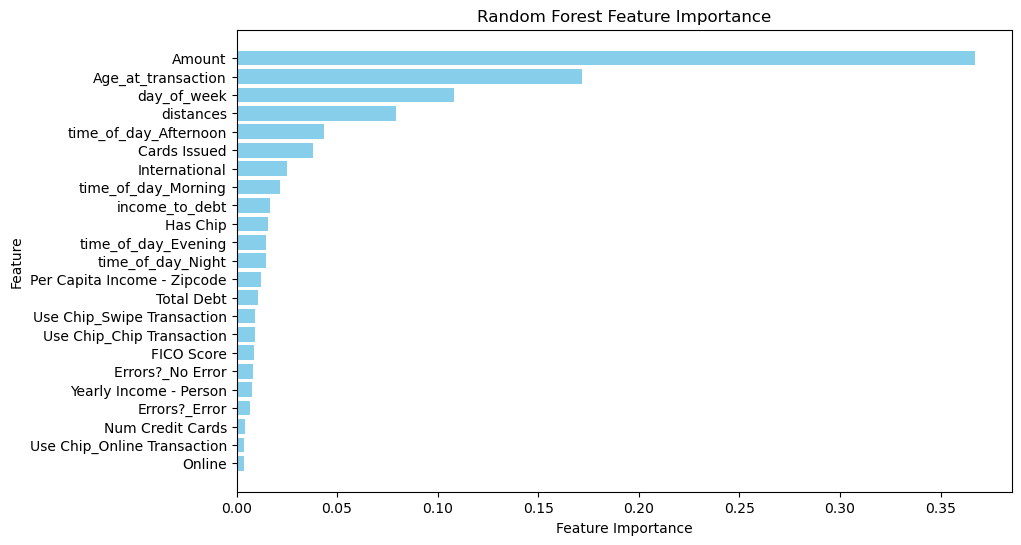

In [285]:
# Extract feature importances and feature names
importances = [importance for importance, _ in feature_importance]
feature_names = [name for _, name in feature_importance]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), importances, align='center', color='skyblue')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

## Clustering and Distribution

/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aleksandra/anaconda3/envs/ola/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureW

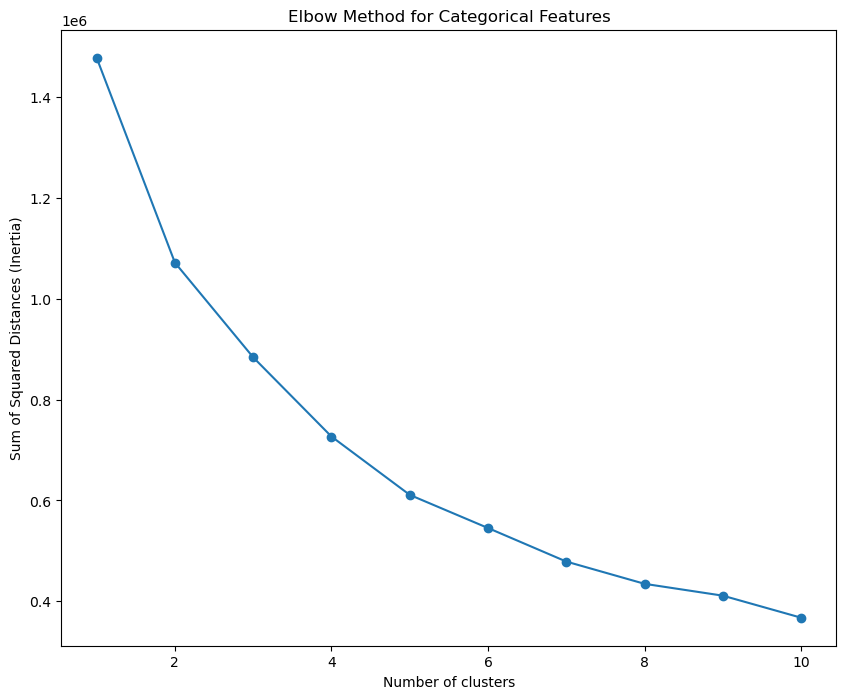

In [292]:
# Dropping the target variable 'Is Fraud?' and any other non-relevant columns for clustering
data_clustering = forest_df.drop(columns=['Is Fraud?', 'timestamp'])

# Defining numerical features
numerical_features = ['Amount', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                      'FICO Score', 'Num Credit Cards', 'Has Chip', 'Cards Issued', 'International',
                      'Online', 'Age_at_transaction', 'income_to_debt', 'day_of_week', 'distances']
# Define categorical features
categorical_features = ['Use Chip', 'Errors?', 'time_of_day']

# Selecting numerical features
data_numerical = data_clustering[numerical_features]

# Selecting categorical features
data_categorical = data_clustering[categorical_features]

# Preprocessing pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Applying preprocessing
data_transformed = preprocessor.fit_transform(data_clustering)

# Elbow Method
inertia = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_transformed)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Categorical Features')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

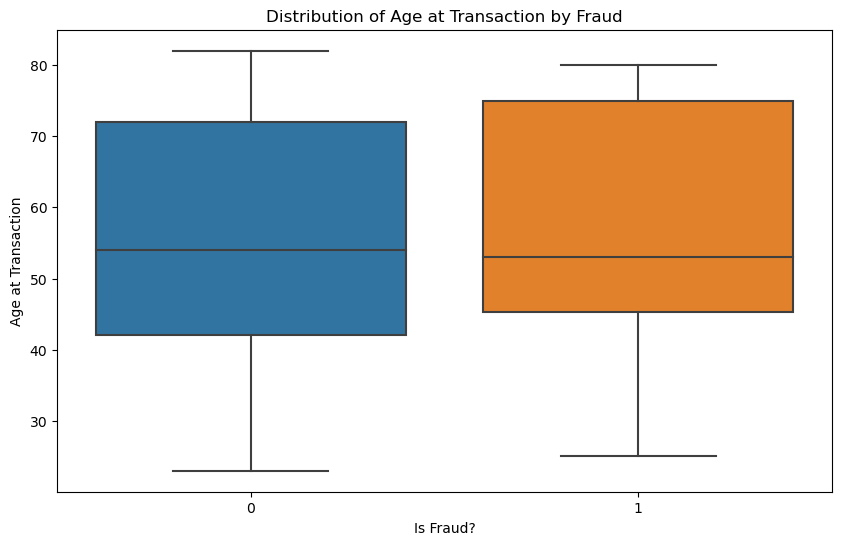

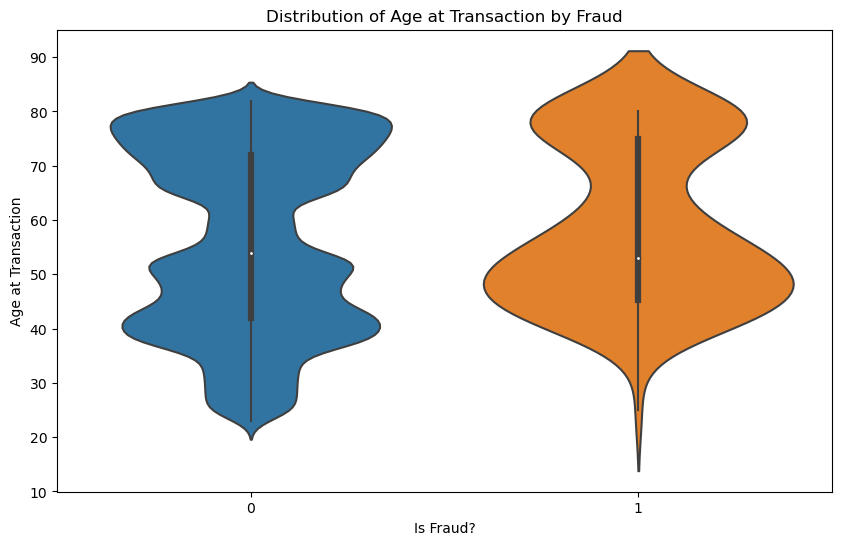

In [307]:
# Box plotting for fraud vs. age_at_transaction
plt.figure(figsize=(10, 6))
sns.boxplot(x='Is Fraud?', y='Age_at_transaction', data=merged_and_drop_df)
plt.title('Distribution of Age at Transaction by Fraud')
plt.xlabel('Is Fraud?')
plt.ylabel('Age at Transaction')
plt.show()

# Violin plotting for fraud vs. age_at_transaction
plt.figure(figsize=(10, 6))
sns.violinplot(x='Is Fraud?', y='Age_at_transaction', data=merged_and_drop_df)
plt.title('Distribution of Age at Transaction by Fraud')
plt.xlabel('Is Fraud?')
plt.ylabel('Age at Transaction')
plt.show()

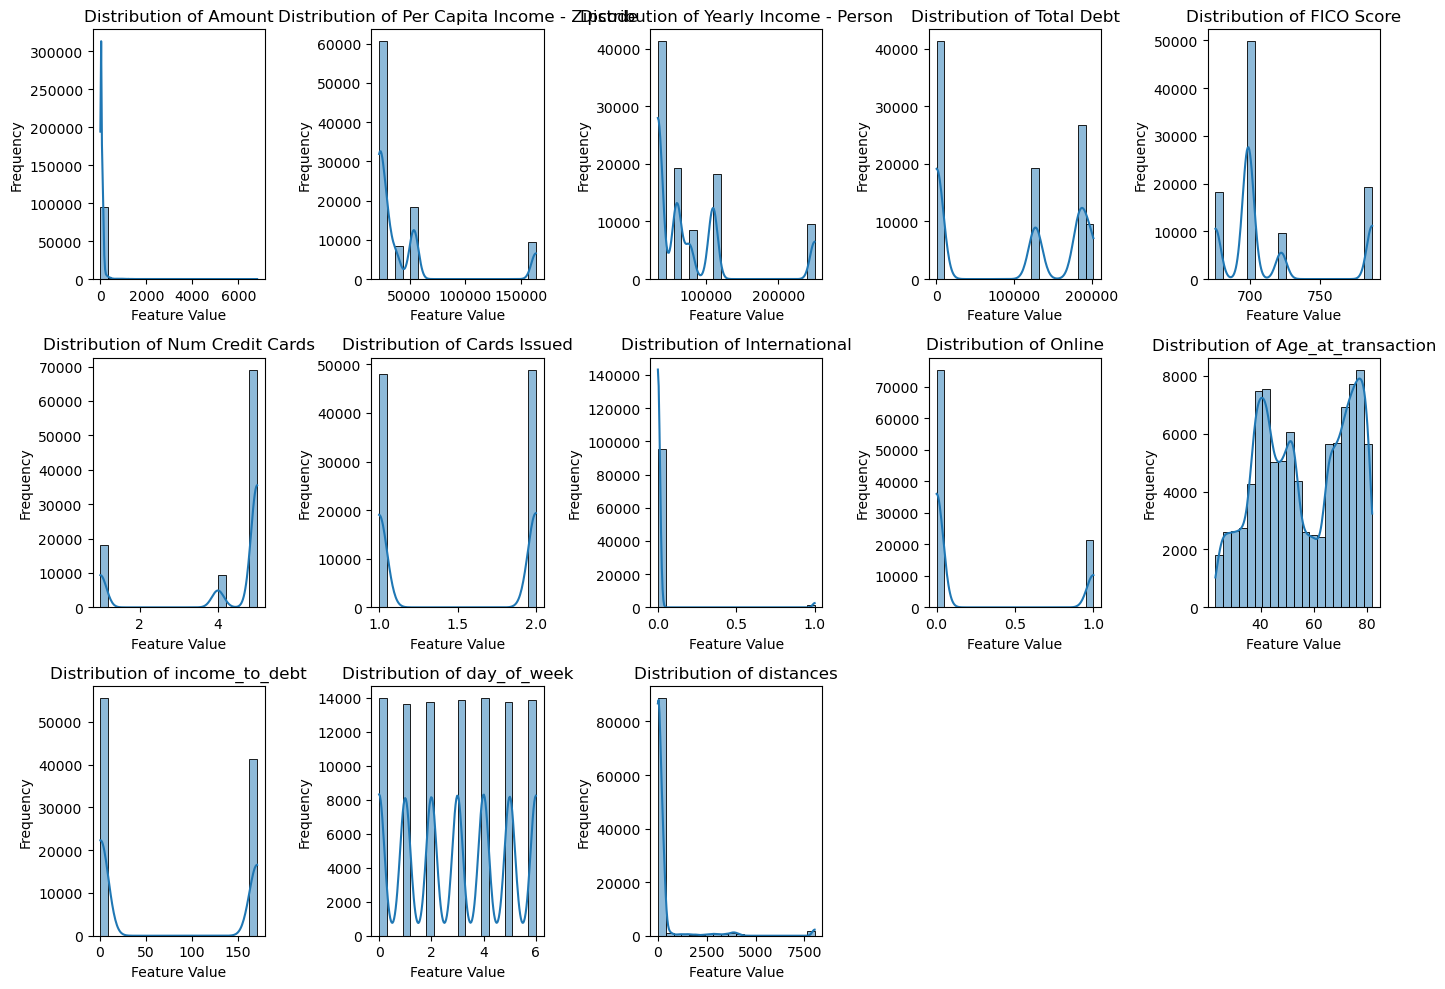

In [310]:
# Checking distribution of numerical features
numerical_features = ['Amount', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                      'FICO Score', 'Num Credit Cards', 'Cards Issued', 'International',
                      'Online', 'Age_at_transaction', 'income_to_debt', 'day_of_week', 'distances']


# Plotting histograms for numerical features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features, start=1):
    plt.subplot(3, 5, i)
    sns.histplot(data_clustering[feature], kde=True, bins=20, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

# Adjusting layout to prevent overlapping titles
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)

plt.tight_layout()
plt.show()
